# NLP get keywords


In [1]:
#import libraries
import numpy as np
import pandas as pd
#Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#importing dataset
files_dir = "../dataset/"
filename = files_dir + "AB_NYC_2019.csv"
df = pd.read_csv(filename)

#data types
for _ in ['id','host_id']:
  df[_] = df[_].astype('object')
df_missing = df.copy(deep=True)
#dropping irrelevant columns
df_missing.drop(['host_id','host_name'], axis=1, inplace=True)
#replacing missing values
df_missing[(df_missing.last_review.isnull()) & (df_missing.reviews_per_month.isnull())] = df_missing[(df_missing.last_review.isnull()) & (df_missing.reviews_per_month.isnull())].replace(np.nan,0)
#dropping irrelevant columns
df_missing.drop(['last_review'], axis=1, inplace=True)
#dropping rows with NaN in listing names
df_missing.dropna(subset = ['name'], inplace= True)
df_missing['name'] = df_missing.name.astype('str')

#feature encoding
df_dummies = pd.get_dummies(df_missing, columns = ['neighbourhood_group'],
                                          prefix = 'NG',drop_first=True)

df_dummies = pd.get_dummies(df_dummies, columns = ['room_type'],
                                          drop_first=True)
df_dummies.drop(['neighbourhood'], axis=1, inplace=True)

# #feature scaling
def scaler_transform(scaler_type, X, exclude_vars = ['latitude', 'longitude', 'id','NG_Brooklyn','NG_Manhattan','NG_Queens','NG_Bronx','NG_Staten Island','room_type_Private room','room_type_Shared room']):
    '''
    Transform the NON-object type data to the selected scaler
    '''
    X_copy = X.copy(deep = True)
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    X_notexcluded= X_copy.loc[:, ~X_copy.columns.isin(exclude_vars)]
    X_withoutobj = X_notexcluded.select_dtypes(exclude=['object'])
    X_withoutobj = X_withoutobj.add_suffix(f'_{scaler_type}')
    # Fit transform the scaler if there are objects in dataset
    if X_withoutobj.shape[1] > 0:
        X_withoutobj = pd.DataFrame(scaler.fit_transform(X_withoutobj[X_withoutobj.columns]),
                                        index=X_withoutobj.index,
                                        columns=X_withoutobj.columns)
        # Concatenate the rest of the data
        X_withexcl = pd.concat([X_withoutobj, X.loc[:, X.columns.isin(exclude_vars)]], axis=1)
        others = [x for x in X.select_dtypes('object') if x not in X_withexcl.columns]
        X_final = pd.concat([X_withexcl,X[others]], axis=1)
    return X_final
  
df_std = scaler_transform('standard', df_dummies)

In [2]:
df_std

,price_standard,minimum_nights_standard,number_of_reviews_standard,reviews_per_month_standard,calculated_host_listings_count_standard,availability_365_standard,id,latitude,longitude,NG_Brooklyn,NG_Manhattan,NG_Queens,NG_Staten Island,room_type_Private room,room_type_Shared room,name
0,-0.015486,-0.294001,-0.320442,-0.551561,-0.034737,1.916324,2539,40.64749,-73.97237,1,0,0,0,1,0,Clean & quiet apt home by the park
1,0.300963,-0.294001,0.487596,-0.445134,-0.156118,1.840345,2595,40.75362,-73.98377,0,1,0,0,0,0,Skylit Midtown Castle
2,-0.011322,-0.196495,-0.522451,-0.683031,-0.186463,1.916324,3647,40.80902,-73.94190,0,1,0,0,1,0,THE VILLAGE OF HARLEM....NEW YORK !
3,-0.265314,-0.294001,5.537831,2.221817,-0.186463,0.617091,3831,40.68514,-73.95976,1,0,0,0,0,0,Cozy Entire Floor of Brownstone
4,-0.302788,0.144776,-0.320442,-0.620426,-0.186463,-0.856891,5022,40.79851,-73.94399,0,1,0,0,0,0,Entire Apt: Spacious Studio/Loft by central park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,-0.344426,-0.245248,-0.522451,-0.683031,-0.156118,-0.788511,36484665,40.67853,-73.94995,1,0,0,0,1,0,Charming one bedroom - newly renovated rowhouse
48891,-0.469340,-0.147742,-0.522451,-0.683031,-0.156118,-0.583369,36485057,40.70184,-73.93317,1,0,0,0,1,0,Affordable room in Bushwick/East Williamsburg
48892,-0.157055,0.144776,-0.522451,-0.683031,-0.186463,-0.651750,36485431,40.81475,-73.94867,0,1,0,0,0,0,Sunny Studio at Historical Neighborhood
48893,-0.406883,-0.294001,-0.522451,-0.683031,-0.034737,-0.841696,36485609,40.75751,-73.99112,0,1,0,0,0,1,43rd St. Time Square-cozy single bed


In [3]:
## Checking the most common words in title
df_nlp = df_std.copy(deep= True)


In [4]:
#Top 10 common words in the comments with CountVectorizer()
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#Natural Language processing 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/daniela/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/daniela/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/daniela/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
def preprocess_text(corpus):
    preprocessed_text = []
    corpus = corpus[corpus.notnull()]#Take out empty comments
    corpus = corpus.str.lower()#lowercase
    corpus = corpus.str.replace('\r\n',"")#remove windows new line
    stop_english=stopwords.words("english")
    corpus = corpus.apply(lambda x: " ".join([i for i in x.split() if i not in set(stopwords.words('english'))]))#remove all the stop words with nltk library
    corpus = corpus.str.replace('[^\w\s]'," ")#remove all punctuation
    corpus = corpus.str.replace('\s+', ' ')#replace x spaces by one space 
    return corpus


In [6]:
texts= df_nlp.name.copy(deep = True)
texts = preprocess_text(texts)

/var/folders/k2/l6mj4_x97qz5wk964hhmxrfh0000gq/T/ipykernel_16880/3077641914.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  corpus = corpus.str.replace('[^\w\s]'," ")#remove all punctuation
/var/folders/k2/l6mj4_x97qz5wk964hhmxrfh0000gq/T/ipykernel_16880/3077641914.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  corpus = corpus.str.replace('\s+', ' ')#replace x spaces by one space


In [7]:
def count_key_words(preprocessed_corpus):
    vec = CountVectorizer().fit(preprocessed_corpus)
    bag_of_words = vec.transform(preprocessed_corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
    cvec_df.head(10)
    #Create the word cloud from the file we have 
    cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

    wordcloud = WordCloud(width=800, height=400)
    wordcloud.generate_from_frequencies(frequencies=cvec_dict)
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return cvec_dict

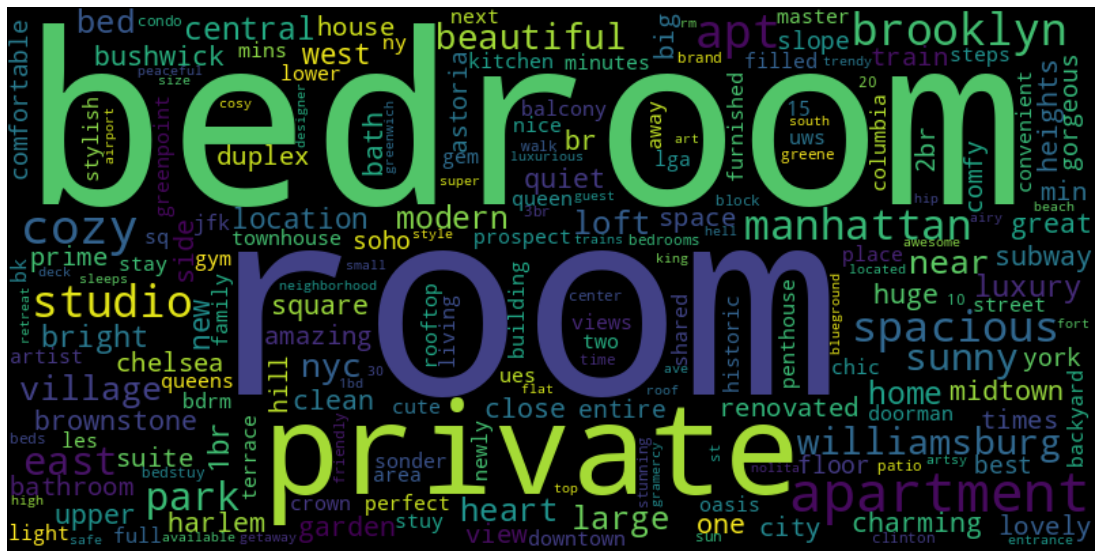

In [9]:
cvec_dict = count_key_words(texts)

In [10]:
cvec_dict

{'room': 10281,
 'bedroom': 8205,
 'private': 7409,
 'apartment': 6760,
 'cozy': 5097,
 'apt': 4740,
 'brooklyn': 4175,
 'studio': 4106,
 'spacious': 3796,
 'manhattan': 3592,
 'park': 3161,
 'east': 3107,
 'sunny': 2945,
 'williamsburg': 2742,
 'beautiful': 2514,
 'near': 2373,
 'village': 2346,
 'nyc': 2285,
 'loft': 2098,
 'large': 2084,
 'heart': 2071,
 'bed': 2068,
 'home': 1885,
 'modern': 1821,
 'central': 1818,
 'bright': 1725,
 'luxury': 1711,
 'location': 1620,
 'west': 1598,
 'new': 1583,
 '1br': 1576,
 'bushwick': 1438,
 'side': 1433,
 'charming': 1387,
 'upper': 1356,
 'one': 1338,
 'br': 1291,
 'midtown': 1283,
 'quiet': 1251,
 'brownstone': 1194,
 'great': 1182,
 'clean': 1163,
 'harlem': 1146,
 'square': 1109,
 'close': 1062,
 'bath': 1035,
 'subway': 1023,
 'garden': 1002,
 'huge': 980,
 'heights': 945,
 'times': 881,
 'prime': 857,
 'duplex': 852,
 'min': 848,
 'city': 822,
 'amazing': 802,
 'house': 781,
 '2br': 776,
 'train': 752,
 'view': 748,
 'chelsea': 728,
 'su